<a href="https://colab.research.google.com/github/likitha888/python/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow numpy matplotlib


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt



In [ ]:

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)


In [ ]:

latent_dim = 2

# Encoder
class Encoder(Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")
        self.conv2 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var


In [ ]:
# Reparameterization
def sample_latent_space(mean, log_var):
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * epsilon


In [ ]:
# Decoder
class Decoder(Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(8 * 8 * 64, activation="relu")
        self.reshape = layers.Reshape((8, 8, 64))
        self.deconv1 = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")
        self.deconv2 = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")
        self.output_layer = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.reshape(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        return self.output_layer(x)


In [ ]:
# VAE Model
class VAE(Model):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        mean, log_var = self.encoder(inputs)
        z = sample_latent_space(mean, log_var)
        return self.decoder(z), mean, log_var


In [ ]:
# VAE Loss Function
def vae_loss(x, x_reconstructed, mean, log_var):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis=[1, 2, 3])
    )

    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
    )

    return reconstruction_loss + kl_loss


In [ ]:
# VAE Loss Function (Fixed)
def vae_loss(x, x_reconstructed, mean, log_var):
    # Reconstruction loss (binary crossentropy)
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x, x_reconstructed), axis=[1, 2, 3]
        )
    )

    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1)
    )

    return reconstruction_loss + kl_loss


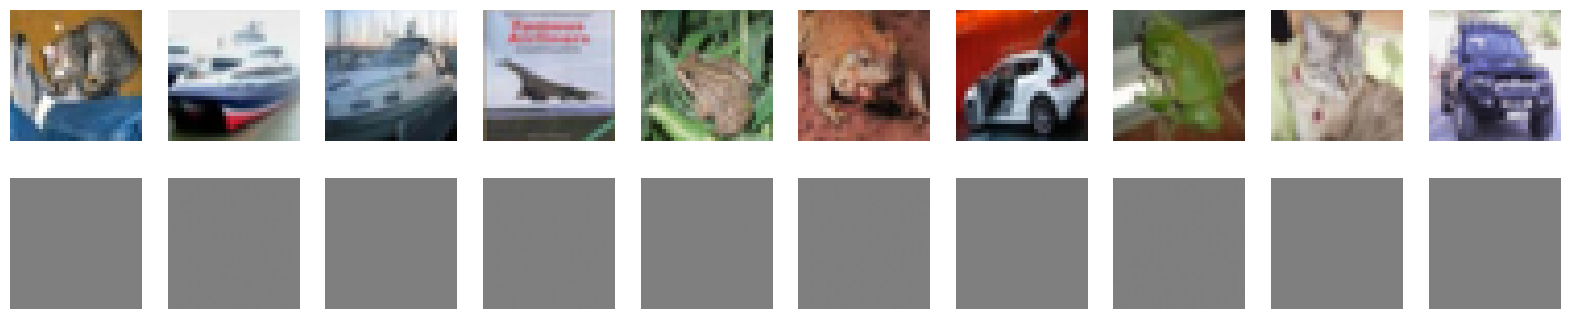

In [ ]:
# Visualize the reconstructed images
def plot_reconstructed_images(x_test, vae):
    num_images = 10
    x_batch = x_test[:num_images]
    x_reconstructed, _, _ = vae(x_batch)

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original Image
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(x_batch[i])
        ax.axis("off")

        # Reconstructed Image
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(x_reconstructed[i].numpy())
        ax.axis("off")

    plt.show()

plot_reconstructed_images(x_test, vae)
